<a href="https://colab.research.google.com/github/Ni7070/Detecting-emergency-message/blob/master/forThesis(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [3]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import torch.nn as nn

#handling text data
from torchtext.legacy import data  
import re
import string

Installing kaggle

In [4]:
!pip install kaggle

Upload kaggle.json API file

In [5]:
# kaggle json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"tahiranishat","key":"4112037cc4740f8918ec1bb74962034f"}'}

Making temporary sample directory

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Kaggle disaster dataset download [kaggle link](https://www.kaggle.com/c/nlp-getting-started)

In [7]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 60.2MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 63.5MB/s]
  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 21.5MB/s]


train and test csv read only text and target column from train data and text data from test data(test data is unlabelled)

In [8]:
train_dir = pd.read_csv('/content/train.csv', usecols = ['text', 'target'])
test_dir = pd.read_csv('/content/test.csv', usecols = ['text'])

output train and test csv files

In [9]:
train_dir.to_csv('train_out.csv')
test_dir.to_csv("test_out.csv")

**Visualizing Data**

In [11]:
train_dir.head() 

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_dir.shape #7613 messages to train

(7613, 2)

In [13]:
test_dir.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
test_dir.shape

(3263, 1)

Checking missing values, No missing values

In [15]:
train_dir.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


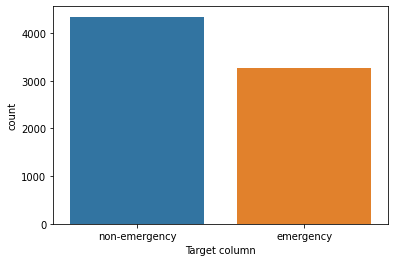

In [18]:
class_names = ['non-emergency', 'emergency']
ax = sns.countplot(train_dir.target)
plt.xlabel('Target column')
ax.set_xticklabels(class_names);

Tokenization

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True)

LABEL = data.LabelField(dtype = torch.float)

In [ ]:
fields1 = [(None, None), ('text',TEXT),('target', LABEL)]
fields2 = [(None, None), ('text',TEXT)]

creating dataset

In [ ]:
train_torch = data.TabularDataset(path = '/content/train_out.csv',format = 'csv',fields = fields1, skip_header = True)
test_torch = data.TabularDataset(path = '/content/test_out.csv',format = 'csv',fields = fields2, skip_header = True)

Random split the train data for train and validation

In [ ]:
import random

train_data, valid_data = train_torch.split(random_state = random.seed(SEED))

Building vocubulary

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:22<00:00, 17600.21it/s]


irterator using bucketiterator

In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_torch), 
    batch_size = BATCH_SIZE,
    # sort_key = lambda x: len(x.src),
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)


RNN model, LSTM was used



In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

Initiate the model

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,398,857 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([20882, 100])


In [ ]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        ...,
        [ 1.5784,  0.3178,  0.0539,  ...,  0.3834,  0.2696, -0.9171],
        [-0.0844,  0.2775, -2.0220,  ...,  0.7102, -0.6400, -1.4728],
        [ 1.7959, -1.7731, -0.9361,  ..., -0.7219,  1.3025,  0.4908]])

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6610, -0.0730,  0.9238,  ..., -0.2256,  0.8148, -0.4405],
        ...,
        [ 1.5784,  0.3178,  0.0539,  ...,  0.3834,  0.2696, -0.9171],
        [-0.0844,  0.2775, -2.0220,  ...,  0.7102, -0.6400, -1.4728],
        [ 1.7959, -1.7731, -0.9361,  ..., -0.7219,  1.3025,  0.4908]])


train

Used Adam optimizer

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

binary_cross_entropy_with_logits loss function

In [ ]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

training the model

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.target)
        
        acc = binary_accuracy(predictions, batch.target)   #calls binary accuracy
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

evaluating the model

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.target)
            
            acc = binary_accuracy(predictions, batch.target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.600 | Train Acc: 67.51%
	 Val. Loss: 0.540 |  Val. Acc: 74.46%
Epoch: 02 | Epoch Time: 0m 2s
	Train Loss: 0.522 | Train Acc: 74.69%
	 Val. Loss: 0.519 |  Val. Acc: 76.44%
Epoch: 03 | Epoch Time: 0m 2s
	Train Loss: 0.488 | Train Acc: 76.80%
	 Val. Loss: 0.501 |  Val. Acc: 77.71%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.450 | Train Acc: 79.02%
	 Val. Loss: 0.563 |  Val. Acc: 74.08%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.411 | Train Acc: 81.44%
	 Val. Loss: 0.474 |  Val. Acc: 78.73%


**Testing Data**

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
model.load_state_dict(torch.load('tut2-model.pt'))

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
test_dir['text']

0                      Just happened a terrible car crash
1       Heard about #earthquake is different cities, s...
2       there is a forest fire at spot pond, geese are...
3                Apocalypse lighting. #Spokane #wildfires
4           Typhoon Soudelor kills 28 in China and Taiwan
                              ...                        
3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259    Storm in RI worse than last hurricane. My city...
3260    Green Line derailment in Chicago http://t.co/U...
3261    MEG issues Hazardous Weather Outlook (HWO) htt...
3262    #CityofCalgary has activated its Municipal Eme...
Name: text, Length: 3263, dtype: object

Single Predictions

*emergency* text (prediction is near to 1)

In [ ]:
predict_sentiment(model, "terrible accident happend")

0.7344905734062195

non-emergency text(prediction is near to 0)

In [ ]:
predict_sentiment(model, "help me with the chores")

0.1346922367811203

predictions of the test data

In [ ]:
tk = []
for i in test_dir["text"]:
  x = predict_sentiment(model, i)
  if abs(x-0)>abs(x-1):
    tk.append(1) 
  else:
    tk.append(0) 

In [ ]:
print(tk)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Appending predictions to the test data

In [ ]:
test_csv = pd.read_csv("/content/test_out.csv")

test_csv['target'] = tk
print(test_csv)

      Unnamed: 0                                               text  target
0              0                 Just happened a terrible car crash       1
1              1  Heard about #earthquake is different cities, s...       1
2              2  there is a forest fire at spot pond, geese are...       1
3              3           Apocalypse lighting. #Spokane #wildfires       1
4              4      Typhoon Soudelor kills 28 in China and Taiwan       1
...          ...                                                ...     ...
3258        3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...       0
3259        3259  Storm in RI worse than last hurricane. My city...       1
3260        3260  Green Line derailment in Chicago http://t.co/U...       1
3261        3261  MEG issues Hazardous Weather Outlook (HWO) htt...       1
3262        3262  #CityofCalgary has activated its Municipal Eme...       1

[3263 rows x 3 columns]


**Result:**

In [ ]:
test_csv.to_csv("test_result_out.csv")